<a href="https://colab.research.google.com/github/vimuth97/Pump-It-Up/blob/main/pump_it_up.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import StandardScaler

# for dirname, _, filenames in os.walk('/content/drive'):
#     for filename in filenames:
#       print(os.path.join(dirname, filename))

train_values = pd.read_csv("/content/drive/MyDrive/Pump it up/training values.csv")
train_labels = pd.read_csv("/content/drive/MyDrive/Pump it up/training labels.csv")
test_data = pd.read_csv("/content/drive/MyDrive/Pump it up/test set.csv")

In [3]:
train_labels.head()

,id,status_group
0,69572,functional
1,8776,functional
2,34310,functional
3,67743,non functional
4,19728,functional


In [4]:
train_values.shape

(59400, 40)

In [5]:
train_values['installer'] = train_values['installer'].str.lower()
train_values['installer'].fillna(0, inplace = True)
train_values['installer'].replace(to_replace = [0, '-'], value = 'missing', inplace = True) 

test_data['installer'] = test_data['installer'].str.lower()
test_data['installer'].fillna(0, inplace = True)
test_data['installer'].replace(to_replace = [0, '-'], value = 'missing', inplace = True) 

Checking whether the dataset is balanced or not

In [6]:
print(train_labels['status_group'].value_counts())

functional                 32259
non functional             22824
functional needs repair     4317
Name: status_group, dtype: int64


In [7]:
test_data.isnull().sum().sort_values(ascending = False).head(10)

scheme_name          7092
scheme_management     969
funder                869
public_meeting        821
permit                737
subvillage             99
ward                    0
lga                     0
district_code           0
region_code             0
dtype: int64

In [8]:
fil_by_year = train_values.loc[train_values['construction_year'] != 0]
year_median = fil_by_year['construction_year'].mean()

train_values['construction_year'].replace(to_replace = 0, value = 1959, inplace = True)    #impute 'construction_year' with 1959 because 1960 is earliest available data

In [9]:
amount = train_values['amount_tsh']
print(amount.max())
print(amount.min())

350000.0
0.0


Standardise `amount_tsh`, `population`, `num_private`, `gps_height` because they have a large ranges and may contain outliers.
However standardisation is not necessary for tree based classifiers. 

In [10]:
train_values[['amount_tsh', 'population', 'num_private', 'gps_height']] = StandardScaler().fit_transform(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])
print(train_values[['amount_tsh', 'population', 'num_private', 'gps_height']])

       amount_tsh  population  num_private  gps_height
0        1.895665   -0.150399    -0.038749    1.041252
1       -0.105970    0.212290    -0.038749    1.054237
2       -0.097630    0.148660    -0.038749    0.025541
3       -0.105970   -0.258570    -0.038749   -0.584751
4       -0.105970   -0.381587    -0.038749   -0.964200
...           ...         ...          ...         ...
59395   -0.102634   -0.116463    -0.038749    0.781553
59396    1.461977   -0.262812    -0.038749    0.784439
59397   -0.105970   -0.381587    -0.038749   -0.964200
59398   -0.105970   -0.381587    -0.038749   -0.964200
59399   -0.105970   -0.063439    -0.038749   -0.688631

[59400 rows x 4 columns]


**Onehot encoding**

In [11]:
train_values_ohe = pd.get_dummies(train_values, prefix=["public_meeting", "permit"], columns=["public_meeting", "permit"], dummy_na=False)
# ohe_2 = pd.get_dummies(train_values.permit, prefix="permit")
train_values_ohe.shape

(59400, 42)

 Remove `region` feature because `region_code` provide coded version of same information

In [12]:
train_values_drop_region = train_values_ohe.drop(['region'], axis=1)

Pre-process `longitude` and `gps_height` by replacing 0 with mean value of each district.
In the dataset region>district>subvillage but subvillage has `na` values hence district is chosen to calculate the mean

In [13]:
print("minimum longitude", train_values_drop_region.longitude.min())
print("number of unavailable latitudes", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude 0.0
number of unavailable latitudes 1812


In [14]:
grouped = train_values_drop_region.groupby("district_code")

def replaceLongitude(group):
  mask = group==0
  group[mask] = group[~mask].mean()
  return group

def replaceLatitude(group):
  mask = group==-0.00000002
  group[mask] = group[~mask].mean()
  return group

mean_longitude = grouped.longitude.transform(replaceLongitude)
mean_latitude = grouped.latitude.transform(replaceLatitude)

train_values_drop_region.longitude = mean_longitude
train_values_drop_region.latitude = mean_latitude

In [15]:
train_values_drop_region.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region_code,district_code,lga,ward,population,recorded_by,scheme_management,scheme_name,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,public_meeting_False,public_meeting_True,permit_False,permit_True
0,69572,1.895665,2011-03-14,Roman,1.041252,roman,34.938093,-9.856322,none,-0.038749,Lake Nyasa,Mnyusi B,11,5,Ludewa,Mundindi,-0.150399,GeoData Consultants Ltd,VWC,Roman,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,0,1,1,0
1,8776,-0.105970,2013-03-06,Grumeti,1.054237,grumeti,34.698766,-2.147466,Zahanati,-0.038749,Lake Victoria,Nyamara,20,2,Serengeti,Natta,0.212290,GeoData Consultants Ltd,Other,NaN,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,0,0,1
2,34310,-0.097630,2013-02-25,Lottery Club,0.025541,world vision,37.460664,-3.821329,Kwa Mahundi,-0.038749,Pangani,Majengo,21,4,Simanjiro,Ngorika,0.148660,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,0,1,0,1
3,67743,-0.105970,2013-01-28,Unicef,-0.584751,unicef,38.486161,-11.155298,Zahanati Ya Nanyumbu,-0.038749,Ruvuma / Southern Coast,Mahakamani,90,63,Nanyumbu,Nanyumbu,-0.258570,GeoData Consultants Ltd,VWC,NaN,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0,1,0,1
4,19728,-0.105970,2011-07-13,Action In A,-0.964200,artisan,31.130847,-1.825359,Shuleni,-0.038749,Lake Victoria,Kyanyamisa,18,1,Karagwe,Nyakasimbi,-0.381587,GeoData Consultants Ltd,NaN,NaN,1959,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,0,1,0,1


In [16]:
#check for correctness of above process
print("minimum longitude:", train_values_drop_region.longitude.min()) 
print("number of unavailable latitudes:", len(train_values_drop_region[(train_values_drop_region['latitude']==-0.00000002)]))

minimum longitude: 29.6071219
number of unavailable latitudes: 0


Preprocess `date_recorded` feature

In [17]:
train_values_drop_region['date_recorded'] =  pd.to_datetime(train_values['date_recorded'])
train_values_drop_region['num_days'] = (train_values_drop_region['date_recorded'] - pd.Timestamp.now())/np.timedelta64(1, 'D')
train_values_drop_region['num_days'] = StandardScaler().fit_transform(train_values_drop_region[['num_days']])
train_values_drop_date = train_values_drop_region.drop(['date_recorded'], axis=1)
print(train_values_drop_date.shape,'\n',train_values_drop_date['num_days'])

(59400, 41) 
 0       -1.141136
1        1.022152
2        0.995223
3        0.911444
4       -0.779092
           ...   
59395    1.195693
59396   -0.979562
59397   -1.057357
59398   -1.159088
59399   -1.114207
Name: num_days, Length: 59400, dtype: float64


In [18]:
encoded_features = ['id','latitude','longitude','gps_height','date_recorded','amount_tsh','num_private',
                    'region_code','district_code','population','public_meeting','construction_year','permit',
                    'num_days','public_meeting_False','public_meeting_True','permit_False','permit_True',
                    'wpt_name','recorded_by']

limit_train = int(train_values_drop_date.shape[0]*0.05/100)


for column in train_values_drop_date.columns:
  if column not in encoded_features:
    train_values_drop_date[column] = train_values_drop_date[column].str.lower()
    feature_values=train_values_drop_date[column].value_counts()
    rare_features=feature_values[feature_values < limit_train]
    train_values_drop_date[column].replace(to_replace = list(rare_features.keys()), value = 'other', inplace = True)
    if ('other' in train_values_drop_date[column].value_counts().index):
      print('Changed', train_values_drop_date[column].value_counts()['other'], 'rows to other in column', column)

    train_values_drop_date[column], _ = train_values_drop_date[column].factorize(na_sentinel=-1)     # label encoding
    
    # same encoding for test data set
    test_data[column] = test_data[column].str.lower()
    test_data[column].replace(to_replace = list(_), value = [ x for x in range(len(list(_)))], inplace = True)
    test_data[column].fillna(-1, inplace = True)
    for i,j in test_data[column].iteritems():
      if type(j) is str:
        test_data.loc[i, column]=len(list(_))

Changed 6391 rows to other in column funder
Changed 6604 rows to other in column installer
Changed 49342 rows to other in column subvillage
Changed 22 rows to other in column lga
Changed 18044 rows to other in column ward
Changed 767 rows to other in column scheme_management
Changed 15267 rows to other in column scheme_name
Changed 6432 rows to other in column extraction_type
Changed 6430 rows to other in column extraction_type_group
Changed 6430 rows to other in column extraction_type_class
Changed 844 rows to other in column management
Changed 943 rows to other in column management_group
Changed 1054 rows to other in column payment
Changed 1054 rows to other in column payment_type
Changed 17 rows to other in column water_quality
Changed 212 rows to other in column source
Changed 278 rows to other in column source_type
Changed 6387 rows to other in column waterpoint_type
Changed 6387 rows to other in column waterpoint_type_group


In [19]:
train_values_drop_name = train_values_drop_date.drop(['wpt_name'], axis=1)    #drop 'wpt_name' (name of the waterpoint) due to highcardinality and less relevance to the prediction
train_values_drop_name = train_values_drop_name.drop(['recorded_by', 'id'], axis=1)    #recorded_by has same value for all records

In [20]:
# Utility functions from Tutorial
def make_mi_scores(X, y, features):
    X_mi = X.copy()
    mi_scores = mutual_info_classif(X_mi, y, discrete_features=features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X_mi.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

In [21]:
train_values_drop_name.head()

,amount_tsh,funder,gps_height,installer,longitude,latitude,num_private,basin,subvillage,region_code,district_code,lga,ward,population,scheme_management,scheme_name,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,public_meeting_False,public_meeting_True,permit_False,permit_True,num_days
0,1.895665,0,1.041252,0,34.938093,-9.856322,-0.038749,0,0,11,5,0,0,-0.150399,0,0,1999,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,-1.141136
1,-0.105970,1,1.054237,1,34.698766,-2.147466,-0.038749,1,0,20,2,1,1,0.212290,1,-1,2010,0,0,0,1,0,1,1,0,0,1,1,1,1,1,0,0,0,0,0,1,1.022152
2,-0.097630,2,0.025541,2,37.460664,-3.821329,-0.038749,2,1,21,4,2,2,0.148660,0,1,2009,0,0,0,0,0,2,2,0,0,0,0,2,2,1,1,0,0,1,0,1,0.995223
3,-0.105970,3,-0.584751,3,38.486161,-11.155298,-0.038749,3,0,90,63,3,3,-0.258570,0,-1,1986,1,1,1,0,0,1,1,0,0,2,2,3,3,0,1,0,0,1,0,1,0.911444
4,-0.105970,2,-0.964200,4,31.130847,-1.825359,-0.038749,1,0,18,1,4,2,-0.381587,-1,-1,1959,0,0,0,2,1,1,1,0,0,3,3,1,1,1,0,0,0,1,0,1,-0.779092


ward                     0.136976
quantity_group           0.104626
quantity                 0.104626
lga                      0.089134
funder                   0.077867
installer                0.071240
longitude                0.069441
latitude                 0.064138
extraction_type          0.062522
extraction_type_group    0.061618
waterpoint_type          0.060230
extraction_type_class    0.058308
scheme_name              0.057266
waterpoint_type_group    0.050883
region_code              0.043761
population               0.037571
amount_tsh               0.037428
num_days                 0.035193
construction_year        0.035164
payment                  0.034318
payment_type             0.034318
source                   0.021771
water_quality            0.019135
gps_height               0.018813
management               0.018464
quality_group            0.017858
scheme_management        0.016637
basin                    0.016004
source_type              0.015785
district_code 

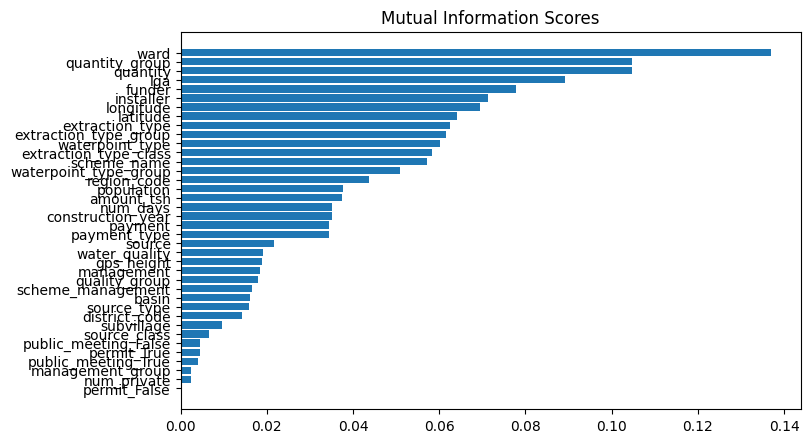

In [22]:
# mutual inofrmation
features = [1, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16,17, 18, 19 ,20, 21, 22, 23, 24, 25, 26, 27, 28, 29]
mi_scores = make_mi_scores(train_values_drop_name, train_labels.status_group, features)
print(mi_scores)

plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

In [23]:
train_values_drop_name = train_values_drop_name.drop(['permit_False'], axis=1) # remove these feature due to low mutual information score

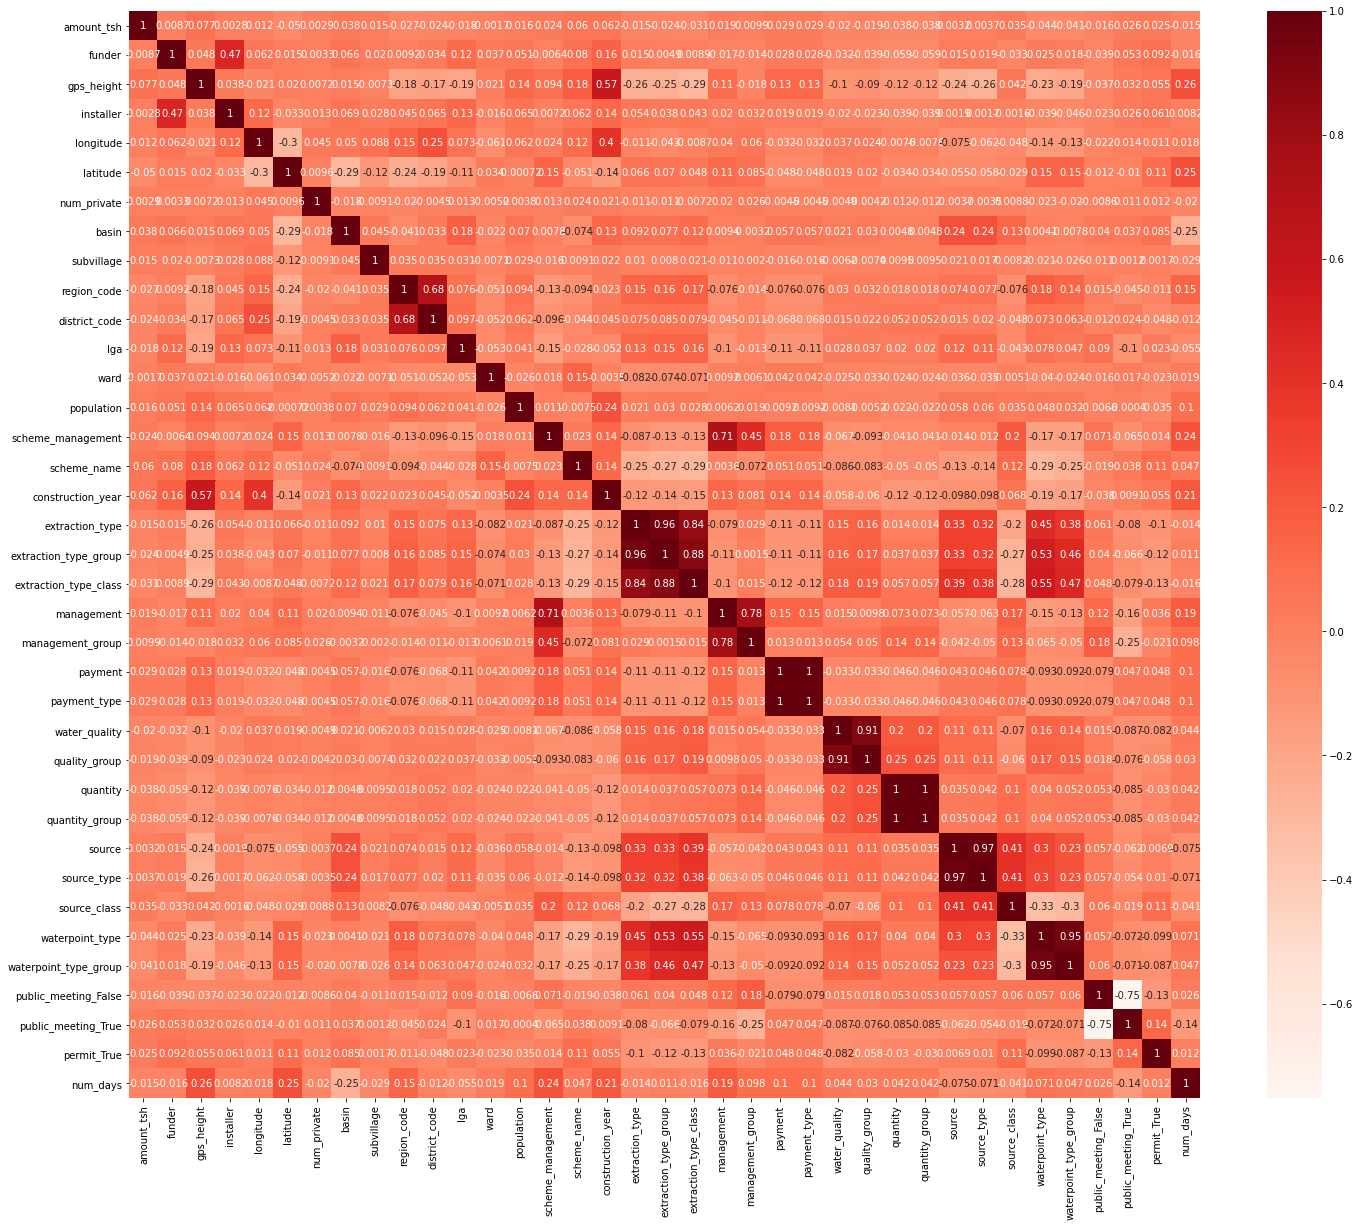

In [24]:
#Using Pearson Correlation
plt.figure(figsize=(24,20))
cor = train_values_drop_name.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Remove following features due to high corelation

In [25]:
train_corr = train_values_drop_name.drop(['extraction_type_group', 'quantity', 'payment', 'quality_group', 'waterpoint_type_group',
                                          'source_type'], axis=1)

In [26]:
# preprocess test data
test_data[['population', 'num_private', 'gps_height', 'amount_tsh']] = StandardScaler().fit_transform(test_data[['population', 'num_private', 'gps_height', 'amount_tsh']])
test_data['construction_year'].replace(to_replace = 0, value = 1959, inplace = True)
test_data_ohe = pd.get_dummies(test_data, prefix=["public_meeting", "permit"], columns=["public_meeting", "permit"], dummy_na=False)


test_data_ohe['date_recorded'] =  pd.to_datetime(test_data_ohe['date_recorded'])
test_data_ohe['num_days'] = (test_data_ohe['date_recorded'] - pd.Timestamp.now())/np.timedelta64(1, 'D')
test_data_ohe['num_days'] = StandardScaler().fit_transform(test_data_ohe[['num_days']])


test_dropped = test_data_ohe.drop(['extraction_type_group', 'quantity', 'payment', 'quality_group', 'waterpoint_type_group', 'source_type', 
                                   'recorded_by', 'id', 'region', 'date_recorded', 'wpt_name', 'permit_False'], axis=1)

grouped = test_dropped.groupby("district_code")
mean_longitude = grouped.longitude.transform(replaceLongitude)
mean_latitude = grouped.latitude.transform(replaceLatitude)


test_dropped.longitude = mean_longitude
test_dropped.latitude = mean_latitude

In [27]:
test_dropped.shape

(14850, 31)

In [28]:
# test-train split
X_train, X_test, Y_train, Y_test = train_test_split(train_corr, train_labels.status_group, test_size=0.2, random_state=23)

print(X_train.shape, X_test.shape)

(47520, 31) (11880, 31)


Hyper parameter tuning

In [29]:
# GridSearch for random forest classifier
param_grid = {
    'bootstrap': [True],
    'criterion': ['gini'],
    'max_depth': [None],
    'max_features': [None],
    'min_samples_leaf': [1, 4],
    'min_samples_split': [10, 20],
    'max_samples': [None],
    'n_estimators': [1000],
}
num_folds = 5

# Create a base model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = num_folds, verbose = 4)

Train and select best model

In [30]:
grid_search.fit(X_train, Y_train)
# grid_search.fit(train_corr, train_labels.status_group)     # for submission
grid_search.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, score=0.808, total= 6.5min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  6.5min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, score=0.811, total= 6.5min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 13.0min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, score=0.804, total= 6.5min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 19.5min remaining:    0.0s


[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, score=0.802, total= 6.5min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=10, n_estimators=1000, score=0.803, total= 6.5min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=20, n_estimators=1000 
[CV]  bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=20, n_estimators=1000, score=0.805, total= 6.4min
[CV] bootstrap=True, criterion=gini, max_depth=None, max_features=None, max_samples=None, min_samples_leaf=1, min_samples_split=20, n_estimators=1000 
[CV]  boot

[Parallel(n_jobs=1)]: Done  20 out of  20 | elapsed: 125.1min finished


{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': None,
 'max_samples': None,
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 1000}

In [31]:
model = grid_search.best_estimator_

Predict using selected model

In [32]:
y_pred = model.predict(X_test)

Evaluation

In [33]:
accuracy = accuracy_score(Y_test, y_pred)
print('Accuracy:', accuracy)
print('\nPredicted Labels')
print('functional','functional_needs_repair','non_functional')
print(confusion_matrix(Y_test,y_pred, normalize='true', labels=['functional','functional needs repair','non functional']))

Accuracy: 0.8134680134680135

Predicted Labels
functional functional_needs_repair non_functional
[[0.89473684 0.02209606 0.0831671 ]
 [0.51764706 0.32588235 0.15647059]
 [0.19875914 0.01329493 0.78794593]]


Save predictions for test set

In [34]:
y_pred = model.predict(test_dropped)
results = pd.DataFrame()
results["id"] = test_data.id
results["status_group"] = y_pred
results.to_csv('final.csv', index=False)